# Chained Hydro-Reservoirs

In this example, two disconnected electrical loads are fed from two reservoirs linked by a river; the first reservoir has inflow from rain onto a water basin.

Note that the two reservoirs are tightly coupled, meaning there is **no time delay** between the first one emptying and the second one filling, as there would be if there were a long stretch of river between the reservoirs. The reservoirs are hence assumed to be close to each other. A time delay is currently not supported in PyPSA.

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

import pypsa

n = pypsa.Network()
n.set_snapshots(range(4))

Add assets to the network.

In [13]:
n.add("Carrier", "reservoir")
n.add("Carrier", "rain")

n.add("Bus", "0 electricity")
n.add("Bus", "1 electricity")

n.add("Bus", "0 reservoir", carrier="reservoir")
n.add("Bus", "1 reservoir", carrier="reservoir")

n.add(
    "Generator",
    "rain",
    bus="0 reservoir",
    carrier="rain",
    p_nom=1000,
    p_max_pu=[0.0, 0.2, 0.7, 0.4],
)

n.add("Load", "0 load", bus="0 electricity", p_set=20)
n.add("Load", "1 load", bus="1 electricity", p_set=30);

The efficiency of a river is the relation between the gravitational potential energy of 1 cubic metre of water in reservoir 0 relative to its turbine versus the potential energy of 1 cubic metre of water in reservoir 1 relative to its turbine. Water can either be spilled without generating electricity or be sent through the turbine to generate power. In both cases, the water goes into the next reservoir.

In [14]:
n.add(
    "Link",
    "spillage",
    bus0="0 reservoir",
    bus1="1 reservoir",
    efficiency=0.5,
    p_nom_extendable=True,
)

n.add(
    "Link",
    "0 turbine",
    bus0="0 reservoir",
    bus1="0 electricity",
    bus2="1 reservoir",
    efficiency=0.9,
    efficiency2=0.5,
    capital_cost=1000,
    p_nom_extendable=True,
)

n.add(
    "Link",
    "1 turbine",
    bus0="1 reservoir",
    bus1="1 electricity",
    efficiency=0.9,
    capital_cost=1000,
    p_nom_extendable=True,
)


n.add(
    "Store",
    "0 reservoir",
    bus="0 reservoir",
    e_cyclic=True,
    e_nom=10_000,
)

n.add(
    "Store",
    "1 reservoir",
    bus="1 reservoir",
    e_cyclic=True,
    e_nom=10_000,
);

In [15]:
n.optimize(n.snapshots)
print("Objective:", n.objective)

Index(['0 electricity', '1 electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35 primals, 75 duals
Objective: 5.56e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-wo7jo18b has 75 rows; 35 cols; 127 nonzeros
Coefficient ranges:
  Matrix [5e-01, 1e+00]
  Cost   [1e+03, 1e+03]
  Bound  [0e+00, 0e+00]
  RHS    [2e+01, 1e+04]
Presolving model
11 rows, 18 cols, 33 nonzeros  0s
8 rows, 15 cols, 27 nonzeros  0s
Dependent equations search running on 8 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
8 rows, 15 cols, 27 nonzeros  0s
Presolve : Reductions: rows 8(-67); columns 15(-20); elements 27(-100)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     5.5555555556e+04 Pr: 8(177.778) 0s
         11     5.5555555556e+04 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-wo7jo18b
Model status        : Optimal
Simplex   iterations: 11
O

<Axes: xlabel='snapshot'>

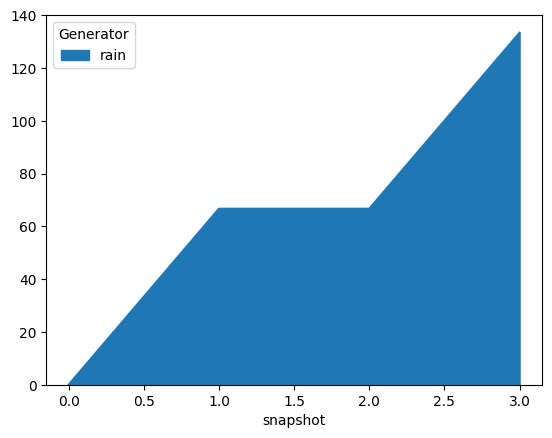

In [16]:
n.generators_t.p.plot.area()

Now, let's have  look at the different outputs of the links.

<Axes: xlabel='snapshot'>

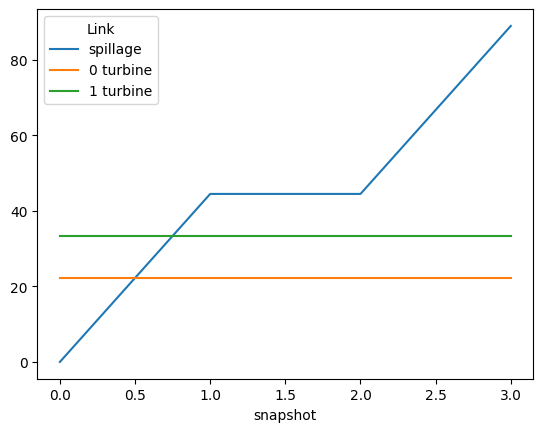

In [17]:
n.links_t.p0.plot()

<Axes: xlabel='snapshot'>

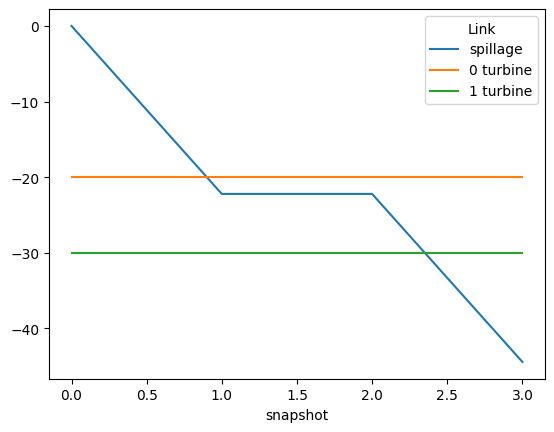

In [18]:
n.links_t.p1.plot()

<Axes: xlabel='snapshot'>

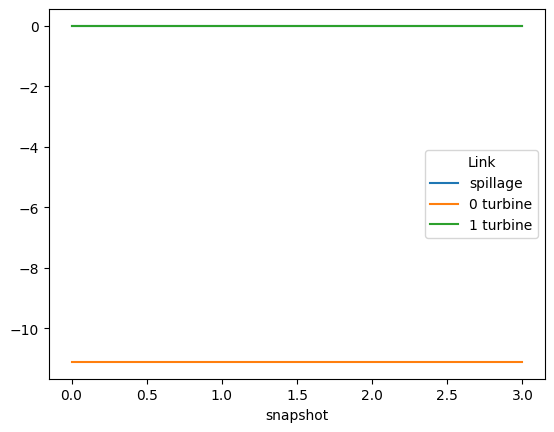

In [19]:
n.links_t.p2.plot()

What are the energy outputs and energy levels at the reservoirs?

In [20]:
pd.DataFrame({attr: n.stores_t[attr]["0 reservoir"] for attr in ["p", "e"]})

,p,e
snapshot,,
0,22.222222,-0.000000
1,-0.000000,-0.000000
2,-0.000000,-0.000000
3,-22.222222,22.222222


In [21]:
pd.DataFrame({attr: n.stores_t[attr]["1 reservoir"] for attr in ["p", "e"]})

,p,e
snapshot,,
0,22.222222,-0.000000
1,-0.000000,-0.000000
2,-0.000000,-0.000000
3,-22.222222,22.222222
